# Pine Marten Occupancy Modelling

This notebook implements occupancy modelling for pine marten data across Ireland. The analysis uses the `unmarked` package and includes:
- Data preparation and covariate extraction
- Model building and evaluation
- Prediction and visualization

## Setup and Dependencies

In [1]:
# Clear workspace
rm(list = ls())


# Set working directory to project root
setwd("/Volumes/external/all-ireland-occupancy-modelling")

# Set CRAN mirror
options(repos = c(CRAN = "https://cloud.r-project.org"))

# Load required packages
library(unmarked)
library(MuMIn)
library(AICcmodavg)
library(ggplot2)
library(tidyverse)
library(AER)


Attaching package: ‘AICcmodavg’


The following objects are masked from ‘package:MuMIn’:

    AICc, DIC, importance


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.4     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


The following object is masked from ‘package:unmarked’:

    vif


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘z

## Data Preparation

### Step 1: Load and Examine Data
We'll start by loading our detection data and landscape covariates at different buffer sizes (1km, 5km, and 10km).

In [2]:
# Load landscape data at different buffer sizes
siteCovs <- read.csv("1.data/1.2.processed/lcm_df_1km_buffer_3035.csv")
siteCovs5km <- read.csv("1.data/1.2.processed/lcm_df_5km_buffer_3035.csv")
siteCovs10km <- read.csv("1.data/1.2.processed/lcm_df_10km_buffer_3035.csv")

# Compare column names across buffer sizes
cols_1km <- colnames(siteCovs)
cols_5km <- colnames(siteCovs5km)
cols_10km <- colnames(siteCovs10km)

# Create comparison dataframe
all_cols <- sort(unique(c(cols_1km, cols_5km, cols_10km)))
col_comparison <- data.frame(
  Column = all_cols,
  In_1km = all_cols %in% cols_1km,
  In_5km = all_cols %in% cols_5km,
  In_10km = all_cols %in% cols_10km
)

View(col_comparison)

Column,In_1km,In_5km,In_10km
<chr>,<lgl>,<lgl>,<lgl>
bait,TRUE,TRUE,TRUE
bog,TRUE,TRUE,TRUE
broadleaf,TRUE,TRUE,TRUE
built,TRUE,TRUE,TRUE
CLC_111,TRUE,TRUE,TRUE
CLC_112,TRUE,TRUE,TRUE
CLC_121,TRUE,TRUE,TRUE
CLC_122,FALSE,TRUE,TRUE
CLC_123,FALSE,TRUE,TRUE


### Step 2: Analyze CLC (CORINE Land Cover) Data
We'll examine the distribution of different land cover types across our buffer sizes.

In [3]:
# Define CLC columns
clc_cols <- grep("^CLC_", colnames(siteCovs5km), value = TRUE)

# Create summary of total area per CLC type
clc_totals <- data.frame(
  CLC_Type = clc_cols,
  Area_1km = sapply(clc_cols, function(clc) sum(siteCovs[[clc]], na.rm = TRUE)),
  Area_5km = sapply(clc_cols, function(clc) sum(siteCovs5km[[clc]], na.rm = TRUE)),
  Area_10km = sapply(clc_cols, function(clc) sum(siteCovs10km[[clc]], na.rm = TRUE))
)

print(clc_totals)

        CLC_Type     Area_1km     Area_5km    Area_10km
CLC_111  CLC_111   0.36363636 7.413609e-01 7.413609e-01
CLC_112  CLC_112  22.48226584 2.574722e+01 2.574722e+01
CLC_121  CLC_121   4.94800275 4.320767e+00 4.320767e+00
CLC_122  CLC_122   0.00000000 1.920000e-02 1.920000e-02
CLC_123  CLC_123   0.00000000 3.200000e-03 3.200000e-03
CLC_124  CLC_124   0.45959596 6.652497e-01 6.652497e-01
CLC_131  CLC_131   3.46757346 2.801704e+00 2.801704e+00
CLC_132  CLC_132   0.00000000 6.240000e-02 6.240000e-02
CLC_133  CLC_133   0.04958678 4.160000e-02 4.160000e-02
CLC_141  CLC_141   0.82702020 1.235344e+00 1.235344e+00
CLC_142  CLC_142  18.08402204 1.339751e+01 1.339751e+01
CLC_211  CLC_211  20.89985078 1.970538e+01 1.970538e+01
CLC_222  CLC_222   0.00000000 1.010130e-01 1.010130e-01
CLC_231  CLC_231 326.41282140 3.426357e+02 3.426357e+02
CLC_242  CLC_242  10.33953168 1.173631e+01 1.173631e+01
CLC_243  CLC_243  22.88458448 2.166007e+01 2.166007e+01
CLC_311  CLC_311  16.17693985 1.147715e+01 1.147

## Detection Data Preparation
We'll now prepare our detection/non-detection data and create the necessary observation covariates.

In [4]:
siteCovs  <- read.csv("1.data/1.2.processed/lcm_df_5km_buffer_3035.csv")
str(siteCovs)

# Load detection data
y <- read.csv("6.provided-scripts/pinemarten201520182020noname.csv")
y <- as.matrix(y)

nrow(y)
head(y)
str(y) 


# Create occasion covariate
occ <- y
for (i in 1:nrow(y)) {
  tmp <- y[i, ]
  n.samp <- sum(!is.na(tmp))
  tmp[!is.na(tmp)] <- 1:n.samp
  occ[i, ] <- tmp
}

View(occ)

# Format bait as dummy covariate
siteCovs$bait[siteCovs$bait == "sunflower"] <- 0
siteCovs$bait[siteCovs$bait == "sunflower and peanuts"] <- 1

# Create observation covariates list
obvsCov <- list(occ = occ)

'data.frame':	706 obs. of  64 variables:
 $ X          : int  1 2 3 4 5 6 7 8 9 10 ...
 $ plot_id    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ CLC_111    : num  0.00154 0 0 0 0 ...
 $ CLC_112    : num  0.495 0 0 0 0 ...
 $ CLC_121    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CLC_122    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CLC_123    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CLC_124    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CLC_131    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CLC_132    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CLC_133    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CLC_141    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CLC_142    : num  0.0615 0 0 0 0 ...
 $ CLC_211    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CLC_222    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CLC_231    : num  0.0431 0.5723 0.7446 0.384 0.6896 ...
 $ CLC_242    : num  0.398 0 0 0 0 ...
 $ CLC_243    : num  0 0.2215 0.0262 0 0 ...
 $ CLC_311    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ CLC_312    : num  0 0.0185 0.1415 0.0976 0 ...
 $ CLC_313    : num  0 0.0523 0 0 0 ...
 $ CLC_321    : num

[1] 706

Day.1,Day.2,Day.3,Day.4,Day.5,Day.6,Day.7,Day.8,Day.9,Day.10,Day.11,Day.12,Day.13,Day.14
0,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA,NA
0,0,0,0,1,1,1,0,0,NA,NA,NA,NA,NA
0,0,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA
0,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA,NA
0,0,0,0,0,1,0,NA,NA,NA,NA,NA,NA,NA
1,0,0,0,1,0,0,0,0,0,NA,NA,NA,NA


 int [1:706, 1:14] 0 0 0 0 0 1 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:14] "Day.1" "Day.2" "Day.3" "Day.4" ...


Day.1,Day.2,Day.3,Day.4,Day.5,Day.6,Day.7,Day.8,Day.9,Day.10,Day.11,Day.12,Day.13,Day.14
1,2,3,4,5,6,7,NA,NA,NA,NA,NA,NA,NA
1,2,3,4,5,6,7,8,9,NA,NA,NA,NA,NA
1,2,3,4,5,6,7,8,NA,NA,NA,NA,NA,NA
1,2,3,4,5,6,7,NA,NA,NA,NA,NA,NA,NA
1,2,3,4,5,6,7,NA,NA,NA,NA,NA,NA,NA
1,2,3,4,5,6,7,8,9,10,NA,NA,NA,NA
1,2,3,4,5,6,7,8,9,10,NA,NA,NA,NA
1,2,3,4,5,6,7,NA,NA,NA,NA,NA,NA,NA
1,2,3,4,5,6,7,8,9,10,NA,NA,NA,NA
1,2,3,4,5,6,7,NA,NA,NA,NA,NA,NA,NA


## Covariate Grouping
We'll group related land cover types into meaningful categories for our analysis.

In [5]:
# Group CLC categories

siteCovs$agrinonpas <- rowSums(siteCovs[, c("CLC_211", "CLC_242", "CLC_243")], na.rm = TRUE)

# pasture land cover 
siteCovs$pasture <- siteCovs$CLC_231

# conifer including conifer and transitional woodland 
siteCovs$conifer <- rowSums(siteCovs[, c("CLC_312", "CLC_324")], na.rm = TRUE)

# mixed wood including broadleaf and mixed forest 
siteCovs$mixedwood <- rowSums(siteCovs[, c("CLC_311", "CLC_313")], na.rm = TRUE)

# open non agriculture including natural grassland, peat bog, moore and heathland
siteCovs$opennoneagri <- rowSums(siteCovs[, c("CLC_321", "CLC_412", "CLC_322")], na.rm = TRUE)

# urban - all urban cover types 
siteCovs$urban <- rowSums(siteCovs[, c("CLC_111", "CLC_112", "CLC_121", "CLC_123", 
                                       "CLC_124", "CLC_131", "CLC_132", "CLC_133", "CLC_142")], na.rm = TRUE)

# make a table of each table categoies mean and sd and range 
# List the columns you want to summarise
groupings <- c("agrinonpas", "pasture", "conifer", "mixedwood", 
               "opennoneagri", "urban")

# Use sapply to generate the summary table
summary_table <- t(sapply(siteCovs[, groupings], function(x) {
  c(Mean = mean(x, na.rm = TRUE),
    SD = sd(x, na.rm = TRUE),
    Min = min(x, na.rm = TRUE),
    Max = max(x, na.rm = TRUE))
}))
# Print the summary table
print(summary_table)


                   Mean         SD Min       Max
agrinonpas   0.07521496 0.13400582   0 0.8032000
pasture      0.48531963 0.31853203   0 1.0000000
conifer      0.12923567 0.18290807   0 0.9307692
mixedwood    0.03084301 0.06123432   0 0.3728000
opennoneagri 0.16697675 0.22931145   0 0.9953846
urban        0.06767849 0.16559346   0 0.9676923


## Data Distribution Analysis
Let's examine the distribution of our covariates to ensure they're suitable for modeling.

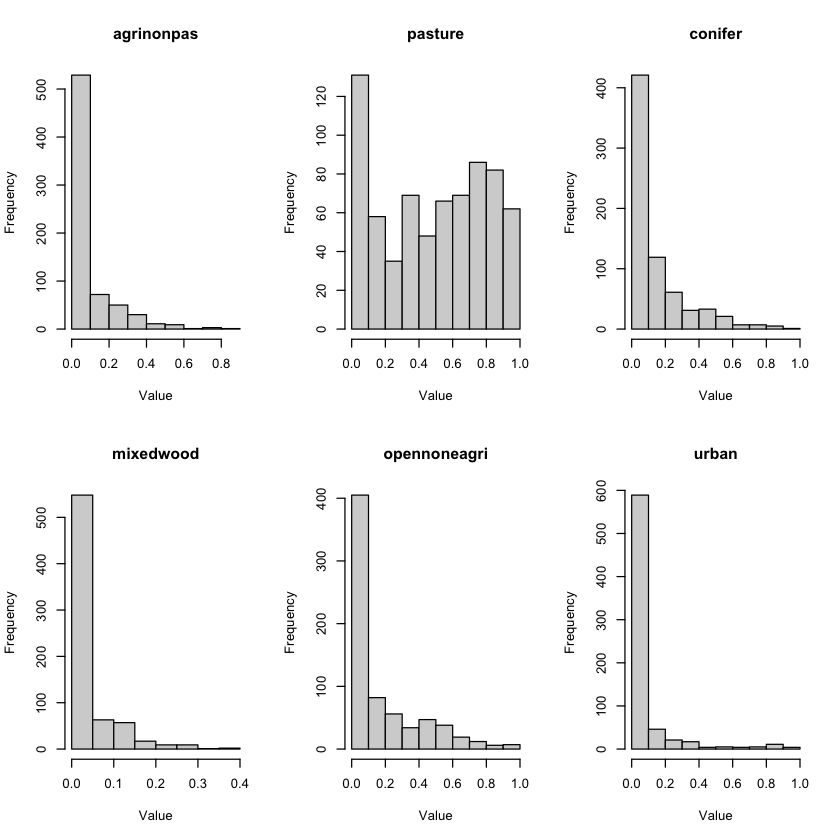

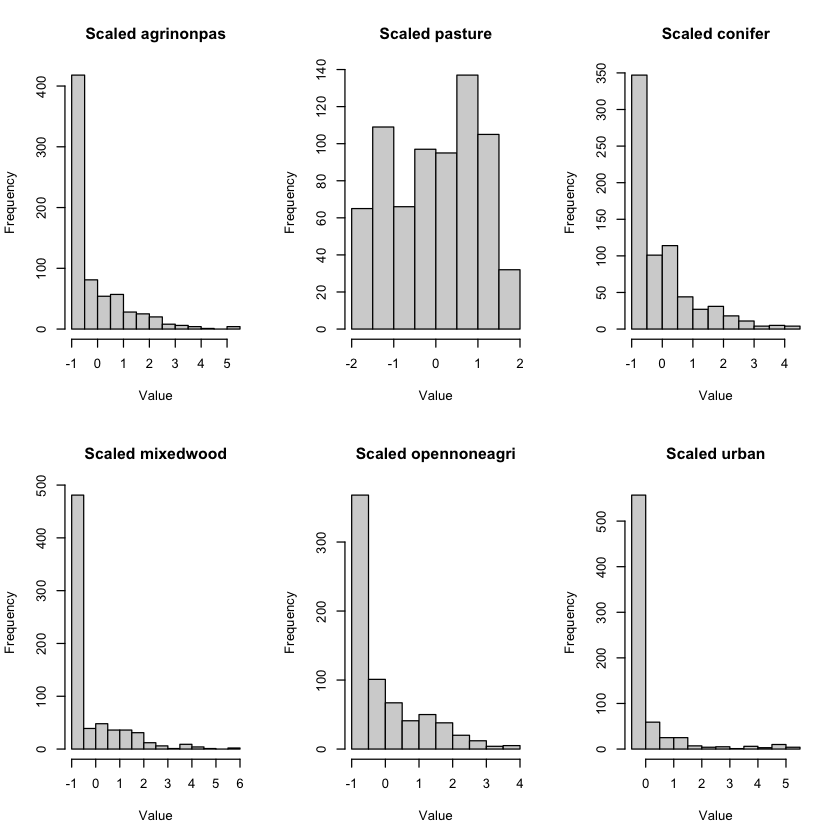

In [6]:
# Create histograms for each covariate
par(mfrow = c(2, 3))
for (var in groupings) {
  hist(siteCovs[[var]], main = var, xlab = "Value")
}

# Create histograms for scaled covariates
par(mfrow = c(2, 3))
for (var in groupings) {
  hist(scale(siteCovs[[var]]), main = paste("Scaled", var), xlab = "Value")
}

## Model Creation
We'll now create our occupancy model using the prepared data.

In [12]:
# Create unmarked frame
umf2 <- unmarkedFrameOccu(y = y, siteCovs = siteCovs, obsCovs = obvsCov)

# Create model
mod1 <- occu(~ scale(occ) + scale(year) + bait
             ~ scale(agrinonpas) 
             + scale(pasture) 
             + scale(conifer) 
             + scale(mixedwood) 
             + scale(urban)
             + scale(year), umf2)

# View model coefficients
coef(mod1)

# View confidence intervals
confint(mod1, type = "state", level = 0.95)

Warning message:
“siteCovs contains characters. Converting them to factors.”


psi(Int) psi(scale(agrinonpas))    psi(scale(pasture)) 
           -1.05962484            -0.03503067            -0.18258331 
   psi(scale(conifer))  psi(scale(mixedwood))      psi(scale(urban)) 
            0.39796251             0.21976371            -0.51455680 
      psi(scale(year))                 p(Int)          p(scale(occ)) 
            0.51369837            -1.44063528             0.10121928 
        p(scale(year))               p(bait1) 
           -0.05065024             1.04163897

,0.025,0.975
psi(Int),-1.2590342,-0.86021550
psi(scale(agrinonpas)),-0.2435730,0.17351166
psi(scale(pasture)),-0.4240465,0.05887986
psi(scale(conifer)),0.1535946,0.64233040
psi(scale(mixedwood)),0.0406749,0.39885252
psi(scale(urban)),-0.8582967,-0.17081689
psi(scale(year)),0.3381298,0.68926690


## Marginal Predictions
We'll create marginal predictions for each covariate to understand their individual effects on occupancy probability.

In [14]:
create_prediction_plot <- function(covariate, data, model) {
  # Create the sequence for the main covariate
  x_seq <- seq(min(data[[covariate]]), max(data[[covariate]]), length.out = 200)
  
  # Create data frame with all covariates
  df <- data.frame(
    x = x_seq,
    conifer = mean(data$conifer),
    agrinonpas = mean(data$agrinonpas),
    pasture = mean(data$pasture),
    mixedwood = mean(data$mixedwood),
    urban = mean(data$urban),
    year = mean(data$year)
  )
  
  # Rename the x column to match the covariate name
  names(df)[1] <- covariate
  
  preds <- predict(model, newdata = df, type = "state")
  preds_df <- cbind(df, preds)
  
  ggplot(preds_df, aes(x = .data[[covariate]], y = Predicted)) +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.15, linetype = "dashed") +
    geom_path(size = 1) +
    labs(x = "Covariates (standardized)", y = "Occupancy probability") +
    theme_bw() +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour = "black"))
}

# print graph


## Landscape Predictions
Finally, we'll make predictions across the entire landscape of Ireland.

In [9]:
# Load landscape data
landscape <- read.csv("1.data/1.3.processedinarc/10kmwidecorine.csv")

# Rename columns to match model matrix
# Get column indices that start with either a number or X followed by a number
clc_cols <- grep("^([0-9]|X[0-9])", colnames(landscape))

# For columns starting with X, remove the X and add CLC_ prefix
# For columns starting with numbers, just add CLC_ prefix
new_names <- gsub("^X([0-9]+)", "CLC_\\1", colnames(landscape)[clc_cols])
new_names <- gsub("^([0-9]+)", "CLC_\\1", new_names)

# Apply the new names
colnames(landscape)[clc_cols] <- new_names


# First rename the X-prefixed columns to match the CLC format
landscape$agrinonpas <- rowSums(landscape[, c("CLC_211", "CLC_242", "CLC_243")], na.rm = TRUE)

# pasture land cover 
landscape$pasture <- landscape$CLC_231

# conifer including conifer and transitional woodland 
landscape$conifer <- rowSums(landscape[, c("CLC_312", "CLC_324")], na.rm = TRUE)

# mixed wood including broadleaf and mixed forest 
landscape$mixedwood <- rowSums(landscape[, c("CLC_311", "CLC_313")], na.rm = TRUE)

# open non agriculture including natural grassland, peat bog, moore and heathland
landscape$opennoneagri <- rowSums(landscape[, c("CLC_321", "CLC_412", "CLC_322")], na.rm = TRUE)

# urban - all urban cover types 
landscape$urban <- rowSums(landscape[, c("CLC_111", "CLC_112", "CLC_121", "CLC_123", 
                                       "CLC_124", "CLC_131", "CLC_132", "CLC_133", "CLC_142")], na.rm = TRUE)

# Add year covariate
landscape$year <- mean(siteCovs$year)

# Make predictions
preds_allireland <- predict(mod1, landscape, type = "state")
preds_df <- cbind(landscape, preds_allireland)

# Save predictions
write.csv(preds_df, "4.modelling/4.modeloutputs/predictions_allirelandmod1.csv", row.names = FALSE)
